# From College to the Pros - Classification
Andy Tan

The aim of this project is to develop a classification model for predicting NBA draft round for collegiate basketball players.

In [660]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import pandas.io.sql as pd_sql
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, make_scorer, fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Importing Data

Main dataset was obtained through sports-reference.com's API (https://sportsreference.readthedocs.io/en/stable/ncaab.html). Data was scraped for yearly and career stats for all division 1 NCAA basketball players from 2010 - 2019. This was subsequently uploaded in SQL.

See 'c2p_data.ipynb' for additiona data collecting code

In [610]:
# Origial SQL database was hosted on an AWS machine. Connection information hidden here for privacy reasons.
connection_args = {
    'host': '***.***.***.*',
    'user': '***',
    'dbname': '***',
    'port': ****
}

connection = pg.connect(**connection_args)

In [789]:
#Select basic stat measures for player's most recent year in college
query1 = """select * from (select year, assists, blocks, defensive_rebounds, effective_field_goal_percentage,
    free_throws, free_throw_attempts, games_played, games_started, height, minutes_played, offensive_rebounds,
    personal_fouls, player_id, points, steals, team_abbreviation, three_point_attempts, three_pointers,
    turnovers, two_point_attempts, two_pointers, usage_percentage, weight,
    row_number() over (partition by player_id order by index desc) as rn from player_stats)sub where rn=2;"""

#Select all stat measures for player's most recent year in college
query2 = """select * from (select *, row_number() over (partition by player_id order by index desc) as rn from player_stats)sub where rn=2;"""

#Read SQL selection into dataframe
stats_df = pd_sql.read_sql(query2, connection)
stats_df['draft_year'] = stats_df.year.apply(lambda x: int(x[0:2] + x[-2:]))
stats_df = stats_df.drop(columns=['year','rn','three_point_percentage'])
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22361 entries, 0 to 22360
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            22361 non-null  int64  
 1   assist_percentage                22224 non-null  float64
 2   assists                          22361 non-null  float64
 3   block_percentage                 22220 non-null  float64
 4   blocks                           22361 non-null  float64
 5   box_plus_minus                   20661 non-null  float64
 6   conference                       22361 non-null  object 
 7   defensive_box_plus_minus         20661 non-null  float64
 8   defensive_rebound_percentage     22219 non-null  float64
 9   defensive_rebounds               22360 non-null  float64
 10  defensive_win_shares             22344 non-null  float64
 11  effective_field_goal_percentage  21554 non-null  float64
 12  field_goal_attempt

Next, we are reading in a dataframe of NBA prospects. Additional code included in 'c2p_data.ipynb'. This will be used to get a subset of the primary dataset.

In [760]:
prospects_df = pd.read_csv('data/prospects_combined.csv', index_col=[0])
prospects_df

,draft_year,round,player_id,college_id_x,class_x,bb_rank,pos,ht_shoes,std_reach,wingspan,std_vert_leap,max_vert_leap
0,2010,1.0,john-wall,kentucky,fr.,1.0,pg,76.00,101.5,81.25,30.0,39.0
1,2010,1.0,evan-turner,ohio-state,jr.,2.0,sg,79.00,103.5,80.00,27.5,34.5
2,2010,1.0,derrick-favors,georgia-tech,fr.,3.0,pf,82.25,110.0,88.00,31.5,35.5
3,2010,1.0,wesley-johnson,syracuse,jr.,4.0,sf,79.25,106.0,85.00,32.0,37.0
4,2010,1.0,demarcus-cousins,kentucky,fr.,7.0,pf/c,82.75,113.0,89.75,23.5,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...
986,2019,0.0,donta-hall,alabama,sr.,93.0,c,NaN,NaN,NaN,NaN,NaN
987,2019,0.0,bennie-boatwright,southern-california,sr.,95.0,pf,NaN,NaN,NaN,NaN,NaN
988,2019,0.0,cj-massinburg,buffalo,sr.,96.0,sg,NaN,NaN,NaN,NaN,NaN
989,2019,0.0,jarrey-foster,smu,sr.,98.0,sf,NaN,NaN,NaN,NaN,NaN


In [761]:
#Merging 2 datasets for all players in the NBA prospects list
r = '({})'.format('|'.join(prospects_df.player_id))
merge_df = stats_df.player_id.str.extract(r, expand=False)
df = pd.merge(prospects_df, stats_df.drop('player_id', 1), left_on=['player_id','draft_year'], right_on=[merge_df,'draft_year'], how='inner')


In [762]:
#Impute missing combine data based on average values by position
df['wingspan'] = df['wingspan'].fillna(df.groupby(['pos']).wingspan.transform('mean'))
df['ht_shoes'] = df['ht_shoes'].fillna(df.groupby(['pos']).ht_shoes.transform('mean'))
df['std_reach'] = df['std_reach'].fillna(df.groupby(['pos']).std_reach.transform('mean'))
df['std_vert_leap'] = df['std_vert_leap'].fillna(df.groupby(['pos']).std_vert_leap.transform('mean'))
df['max_vert_leap'] = df['max_vert_leap'].fillna(df.groupby(['pos']).max_vert_leap.transform('mean'))
df = df.dropna()

In [763]:
#Save final dataframe to pickle
df.info()
df.to_pickle('c2p_df.pkl')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 52 to 920
Data columns (total 62 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   draft_year                       740 non-null    int64  
 1   round                            740 non-null    float64
 2   player_id                        740 non-null    object 
 3   college_id_x                     740 non-null    object 
 4   class_x                          740 non-null    object 
 5   bb_rank                          740 non-null    float64
 6   pos                              740 non-null    object 
 7   ht_shoes                         740 non-null    float64
 8   std_reach                        740 non-null    float64
 9   wingspan                         740 non-null    float64
 10  std_vert_leap                    740 non-null    float64
 11  max_vert_leap                    740 non-null    float64
 12  index                

In [838]:
#Reading dataframe from pickle
df = pd.read_pickle('c2p_df.pkl')
df

,draft_year,round,player_id,college_id_x,class_x,bb_rank,pos,ht_shoes,std_reach,wingspan,...,true_shooting_percentage,turnover_percentage,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,weight,win_shares,win_shares_per_40_minutes
52,2011,1.0,kyrie-irving,duke,fr.,3.0,pg,75.500000,99.000000,76.000000,...,0.697,16.4,27.0,65.0,0.569,37.0,26.4,180.0,2.4,0.320
53,2011,1.0,derrick-williams,arizona,so.,1.0,sf/pf,80.750000,108.000000,85.500000,...,0.690,15.7,100.0,306.0,0.601,184.0,28.9,235.0,7.9,0.279
54,2011,1.0,tristan-thompson,texas,fr.,9.0,pf,80.750000,108.500000,85.250000,...,0.639,13.8,74.0,186.0,0.495,92.0,26.0,193.0,5.0,0.190
55,2011,1.0,tristan-thompson,texas,fr.,9.0,pf,80.750000,108.500000,85.250000,...,0.536,12.7,64.0,315.0,0.546,172.0,22.4,225.0,5.5,0.200
56,2011,1.0,brandon-knight,kentucky,fr.,4.0,pg/sg,75.250000,98.500000,78.750000,...,0.553,16.8,120.0,282.0,0.461,130.0,27.0,185.0,5.3,0.157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2019,0.0,donta-hall,alabama,sr.,93.0,c,83.857143,110.809524,88.104651,...,0.648,11.9,37.0,215.0,0.614,132.0,16.9,230.0,4.5,0.196
917,2019,0.0,bennie-boatwright,southern-california,sr.,95.0,pf,81.281977,106.872093,85.281977,...,0.600,8.9,46.0,206.0,0.519,107.0,24.7,235.0,4.8,0.186
918,2019,0.0,cj-massinburg,buffalo,sr.,96.0,sg,77.156566,100.383838,80.542929,...,0.615,8.3,47.0,196.0,0.541,106.0,23.1,194.0,7.1,0.253
919,2019,0.0,jarrey-foster,smu,sr.,98.0,sf,79.470339,103.940678,83.145763,...,0.453,15.8,23.0,64.0,0.391,25.0,20.3,220.0,0.5,0.052


Checking class balance. It looks like there is some imbalance but not too severe. We will the leave sample as is.

In [765]:
print("# Undrafted: {} ({:5.2f}%)".format(df['round'].value_counts()[0], 100*df['round'].value_counts()[0]/df['round'].count()))
print("# 1st Round: {} ({:5.2f}%)".format(df['round'].value_counts()[1], 100*df['round'].value_counts()[1]/df['round'].count()))
print("# 2nd Round: {} ({:5.2f}%)".format(df['round'].value_counts()[2], 100*df['round'].value_counts()[2]/df['round'].count()))

# Undrafted: 329 (44.46%)
# 1st Round: 224 (30.27%)
# 2nd Round: 187 (25.27%)


Initial EDA

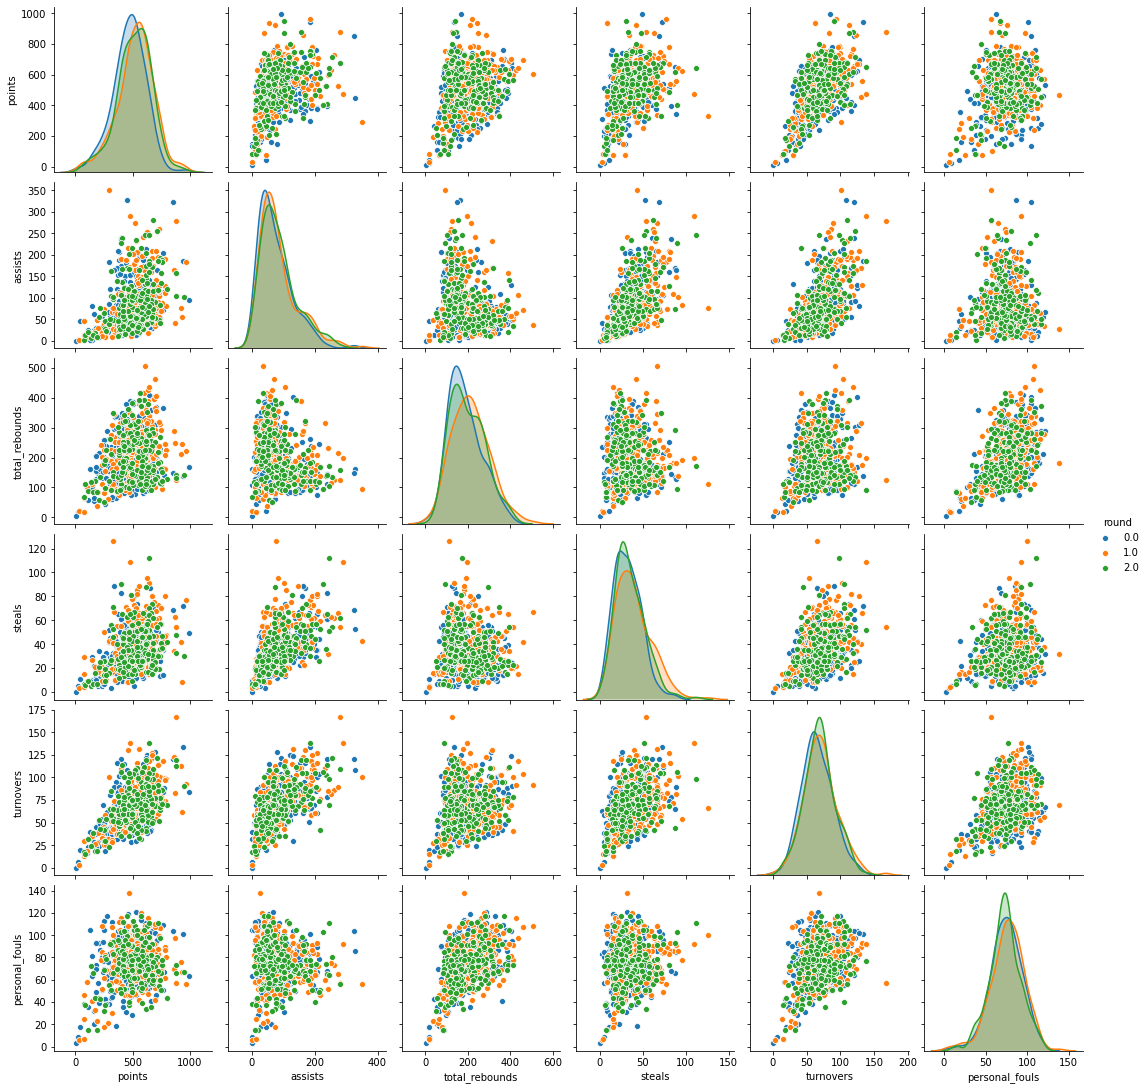

In [767]:
#Pairplot of basic stats
sns.pairplot(df.loc[:,['round','points','assists','total_rebounds','steals','turnovers','personal_fouls']], hue='round')

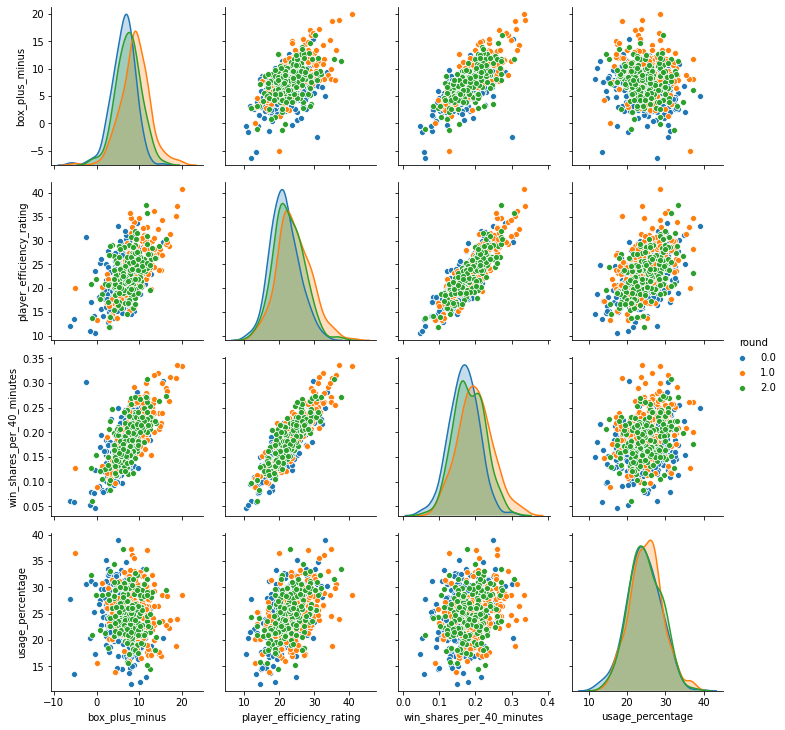

In [768]:
#Pairplot of advanced stats
sns.pairplot(df.loc[:,['round','box_plus_minus','player_efficiency_rating','win_shares_per_40_minutes','usage_percentage']], hue='round')

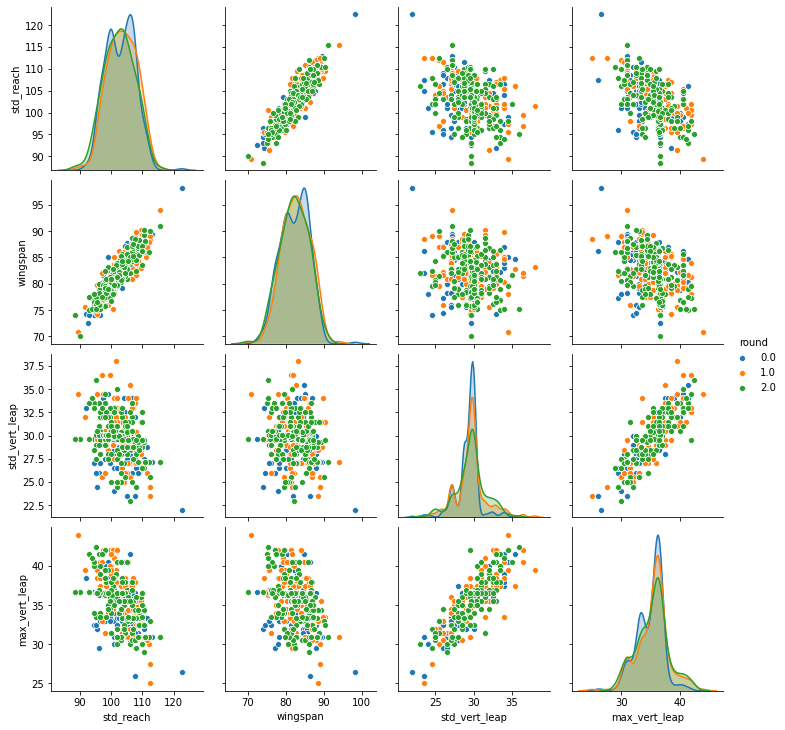

In [769]:
#Pairplot of combine stats
sns.pairplot(df.loc[:,['round','height','std_reach','wingspan','std_vert_leap','max_vert_leap']], hue='round')

There are no clear differentiating features to start out with. It appears advanced stats may be slightly better. We will need to watch out for colinearity with these.

# Classification Modeling

Start with train/test split. We will choose 1 feature to start out with.

In [770]:
#Train/Test split
y = df['round']
X = df.loc[:,['player_efficiency_rating']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

### knn

In [772]:
# optimizing value of K
k_range = list(range(1,31))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

# examine the best KNN model
print(f'Best KNN score: {grid.best_score_}')
print(f'Best KNN parameters: {grid.best_params_}')

Best KNN score: 0.4607909604519773
Best KNN parameters: {'n_neighbors': 6}


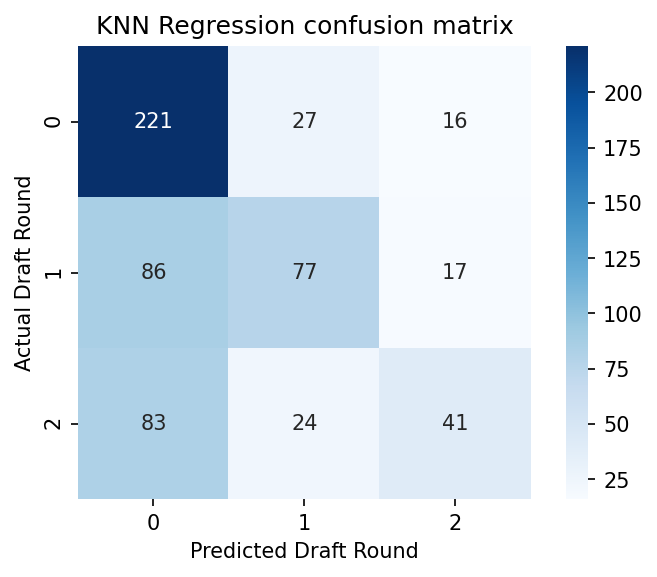

In [773]:
# Confusion matrix on entire training set with best parameters
knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn.fit(X_train,y_train)
y_pred = knn.predict(X_train)
knn_confusion = confusion_matrix(y_train, y_pred)
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Draft Round')
plt.ylabel('Actual Draft Round')
plt.title('KNN Regression confusion matrix');

### Logistic regression

In [774]:
#applying standard scaler
std = StandardScaler()
std.fit(X_train)
X_tr_std = std.transform(X_train)

In [775]:
# tuning Logistic Regression parameters
c_range = 10**np.linspace(-3,3,7)
param_grid = dict(C=c_range, solver=['liblinear'])

grid = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy')
grid.fit(X_tr_std, y_train)

# examine the best LR model
print(f'Best Logistic Regression score: {grid.best_score_}')
print(f'Best Logistic Regression parameters: {grid.best_params_}')

Best Logistic Regression score: 0.4914124293785311
Best Logistic Regression parameters: {'C': 0.1, 'solver': 'liblinear'}


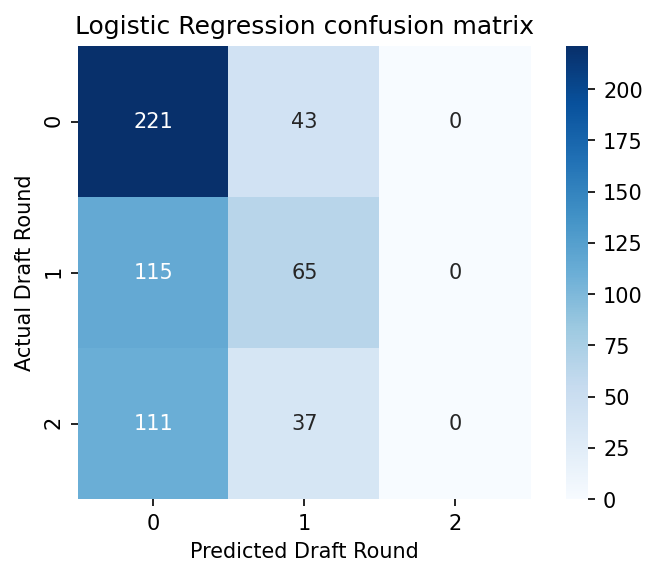

In [776]:
# Confusion matrix for entire training set with best parameters
lr = LogisticRegression(C=grid.best_params_['C'], solver='liblinear')
lr.fit(X_tr_std,y_train)
prediction_hard = lr.predict(X_tr_std)
lr_confusion = confusion_matrix(y_train, prediction_hard)
plt.figure(dpi=150)
sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Draft Round')
plt.ylabel('Actual Draft Round')
plt.title('Logistic Regression confusion matrix');

### Random Forest

In [777]:
# tuning Random Forest parameters
est_range = list(int(x) for x in np.linspace(100,500,5))
depth_range = list(int(x) for x in np.linspace(10,50,5))
param_grid = dict(n_estimators=est_range, max_depth=depth_range)

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

# examine the best LR model
print(f'Best Random Forest score: {grid.best_score_}')
print(f'Best Random Forest parameters: {grid.best_params_}')

Best Random Forest score: 0.39330508474576276
Best Random Forest parameters: {'max_depth': 10, 'n_estimators': 100}


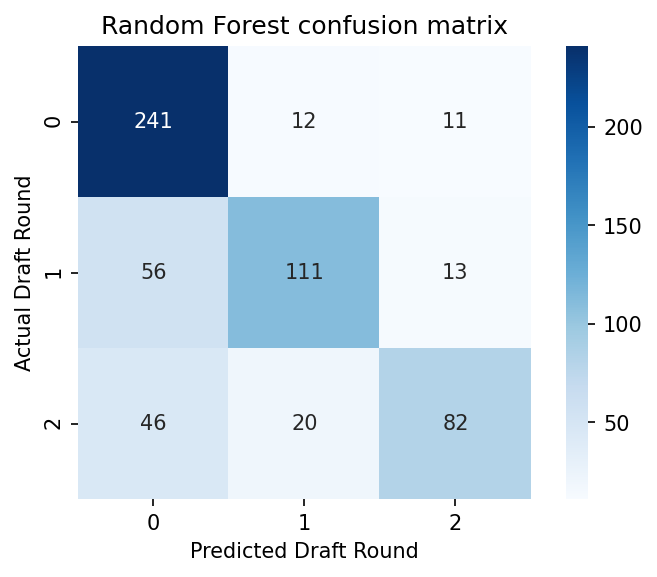

In [635]:
# Confusion matrix for entire training set with best parameters
rf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], max_depth=grid.best_params_['max_depth'])
rf.fit(X_train,y_train)
y_pred = rf.predict(X_train)
rf_confusion = confusion_matrix(y_train,y_pred)
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Draft Round')
plt.ylabel('Actual Draft Round')
plt.title('Random Forest confusion matrix');

Our initial models have modest accuracy scores around 0.4-0.5. Let's add more features.

In [791]:
def get_model_scores(X,y):
    '''
    This function will print scores for KNN, logistic regression, and random forest. Used to track progress after adding features
    
    args:
        X: features
        y: outcome
    
    '''
    #KNN
    k_range = list(range(1,31))
    param_grid = dict(n_neighbors=k_range)

    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y)

    print(f'Best KNN score: {grid.best_score_}')
    print(f'Best KNN parameters: {grid.best_params_}')
    
    #Logistic Regression
    std = StandardScaler()
    X_std = std.fit_transform(X)
    c_range = 10**np.linspace(-3,3,7)
    param_grid = dict(C=c_range, solver=['liblinear'])

    grid = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy')
    grid.fit(X_std, y)

    print(f'Best Logistic Regression score: {grid.best_score_}')
    print(f'Best Logistic Regression parameters: {grid.best_params_}')
    
    #Random Forest
    est_range = list(int(x) for x in np.linspace(100,500,5))
    depth_range = list(int(x) for x in np.linspace(10,50,5))
    param_grid = dict(n_estimators=est_range, max_depth=depth_range)

    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y)
    
    print(f'Best Random Forest score: {grid.best_score_}')
    print(f'Best Random Forest parameters: {grid.best_params_}')

## Model Tuning

### Adding features for basic college production stats

In [839]:
#Convert cumulative stats to per game stats
df['ppg'] = df['points']/df['games_played']
df['apg'] = df['assists']/df['games_played']
df['rpg'] = df['total_rebounds']/df['games_played']
df['spg'] = df['steals']/df['games_played']
df['tpg'] = df['turnovers']/df['games_played']
df['fpg'] = df['personal_fouls']/df['games_played']

In [781]:
#Retrain model
y = df['round']
X = df.loc[:,['player_efficiency_rating','ppg','apg','rpg','spg','tpg','fpg','true_shooting_percentage']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)

In [782]:
get_model_scores(X_train, y_train)

Best KNN score: 0.46110169491525427
Best KNN parameters: {'n_neighbors': 29}
Best Logistic Regression score: 0.5117231638418078
Best Logistic Regression parameters: {'C': 10.0, 'solver': 'liblinear'}
Best Random Forest score: 0.47454802259887
Best Random Forest parameters: {'max_depth': 10, 'n_estimators': 500}


### Adding advanced college statistics

In [840]:
y = df['round']
X = df.loc[:,['ppg','apg','rpg','spg','tpg','fpg','true_shooting_percentage',
             'box_plus_minus','player_efficiency_rating','win_shares','usage_percentage']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)

In [784]:
get_model_scores(X_train, y_train)

Best KNN score: 0.5387570621468927
Best KNN parameters: {'n_neighbors': 25}
Best Logistic Regression score: 0.5555084745762712
Best Logistic Regression parameters: {'C': 0.1, 'solver': 'liblinear'}
Best Random Forest score: 0.5132485875706214
Best Random Forest parameters: {'max_depth': 10, 'n_estimators': 400}


### Adding additional features

In [841]:
#Convert class year in college to numerical value
classes = {'fr.':1, 'so.':2, 'jr.':3, 'sr.':4}
df['class_num'] = df['class_x'].map(classes)

#Standardizing physical attributes by dividing by mean value at that player's position
df['height'] = df.height.apply(lambda x: int(x[0])*12 + int(x[2:]))
df['height_std'] = df['height'].div(df.groupby(['pos']).height.transform('mean'))
df['wingspan_std'] = df['wingspan'].div(df.groupby(['pos']).wingspan.transform('mean'))
df['vert_std'] = df['max_vert_leap'].div(df.groupby(['pos']).max_vert_leap.transform('mean'))
df['reach_std'] = df['std_reach'].div(df.groupby(['pos']).std_reach.transform('mean'))

#Creating a single metric for physical length
df['tot_reach'] = df['reach_std'] * df['wingspan_std']


In [842]:
y = df['round']
X = df.loc[:,['ppg','apg','rpg','spg','tpg','fpg','true_shooting_percentage',
             'box_plus_minus','player_efficiency_rating','win_shares_per_40_minutes','usage_percentage',
             'vert_std','tot_reach','class_num']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)

In [843]:
get_model_scores(X_train, y_train)

Best KNN score: 0.5775988700564973
Best KNN parameters: {'n_neighbors': 22}
Best Logistic Regression score: 0.6452824858757062
Best Logistic Regression parameters: {'C': 1.0, 'solver': 'liblinear'}
Best Random Forest score: 0.6588135593220339
Best Random Forest parameters: {'max_depth': 40, 'n_estimators': 500}


### Feature Importance

It looks like Logistic Regression and Random Forest both perform similarly. Let's tune each by checking feature importance.

#### Logistic Regression features

In [845]:
#Check coefficients for logistic regression
std = StandardScaler()
std.fit(X_train)
X_tr_std = std.transform(X_train)
lr = LogisticRegression(C=1.0, solver='liblinear')
lr.fit(X_tr_std,y_train)
prediction_hard = lr.predict(X_tr_std)
print("The score for Logistic Regression is")
print("Train set: {:6.2f}%".format(100*lr.score(X_tr_std, y_train)))

f_dict={}
for num in range(3):
    f = list(feat for feat in zip(X_train.columns, np.abs(lr.coef_[num])))
    f_dict[num] = f

print(sorted(f_dict[0], key=lambda x: x[1], reverse=True))
print(sorted(f_dict[1], key=lambda x: x[1], reverse=True))
print(sorted(f_dict[2], key=lambda x: x[1], reverse=True))

The score for Logistic Regression is
Train set:  66.22%
[('class_num', 1.359776316188456), ('box_plus_minus', 0.7530676609049781), ('win_shares_per_40_minutes', 0.39207591596261787), ('tpg', 0.36804556597591404), ('fpg', 0.3356997359438374), ('ppg', 0.33241216196806084), ('rpg', 0.27876955447322127), ('player_efficiency_rating', 0.243552447243182), ('vert_std', 0.23978999993003516), ('apg', 0.2172237213530917), ('spg', 0.20976457436393348), ('tot_reach', 0.07409084487390027), ('true_shooting_percentage', 0.0658153768007926), ('usage_percentage', 0.021072660019710858)]
[('class_num', 1.68713055487157), ('box_plus_minus', 0.8353275805026101), ('spg', 0.40972838093956176), ('win_shares_per_40_minutes', 0.3273992733217815), ('ppg', 0.24128582133412427), ('vert_std', 0.23677724972607872), ('true_shooting_percentage', 0.18533478680269783), ('apg', 0.17003448062536894), ('tpg', 0.16467788153155105), ('usage_percentage', 0.09434024851645165), ('fpg', 0.05976466189048676), ('rpg', 0.04256438433

'tot_reach' and 'usage_percentage' had low coefficient values in all 3 classes. These were removed along with 'win_shares' and 'player_efficiency_rating' as we previously saw these have high colinearity with box_plus_minus.

In [850]:
#Checking model with less features
y_lr = df['round']
X_lr = df.loc[:,['ppg','apg','rpg','spg','tpg','fpg','true_shooting_percentage',
             'box_plus_minus',
             'vert_std','class_num']]

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr,y_lr, test_size=0.2, random_state=12)

In [852]:
#The logistic regression model performs similarly with less features
get_model_scores(X_lr_train, y_lr_train)

Best KNN score: 0.6012146892655367
Best KNN parameters: {'n_neighbors': 30}
Best Logistic Regression score: 0.6436158192090395
Best Logistic Regression parameters: {'C': 0.001, 'solver': 'liblinear'}
Best Random Forest score: 0.6385593220338983
Best Random Forest parameters: {'max_depth': 40, 'n_estimators': 100}


#### Random Forest features

In [854]:
rf = RandomForestClassifier(n_estimators=500, max_depth=40)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_train)
print("The score for Random Forest is")
print("Train set: {:6.2f}%".format(100*rf.score(X_train, y_train)))

f_dict=zip(X_train.columns, rf.feature_importances_)
    
print(sorted(f_dict, key=lambda x: x[1], reverse=True))

The score for Random Forest is
Train set:  99.83%
[('class_num', 0.13277586077646236), ('tot_reach', 0.12384940932015599), ('box_plus_minus', 0.10292119646084412), ('vert_std', 0.07212911283983334), ('win_shares_per_40_minutes', 0.06647216898468702), ('spg', 0.0642766953635755), ('player_efficiency_rating', 0.063858386980703), ('fpg', 0.06047174049997555), ('true_shooting_percentage', 0.05519948393817107), ('ppg', 0.05405996086379433), ('rpg', 0.05368448304707358), ('tpg', 0.05303491831948638), ('apg', 0.05168285456959981), ('usage_percentage', 0.045583728035637976)]


Overall the difference in feature importance is smaller top to bottom. Here, 'tot_reach' is more important. 'usage_percentage' is again low on the list like in LR. We'll remove this along with 'win_shares' and 'player_efficiency_rating'

In [855]:
#Checking model with less features
y_rf = df['round']
X_rf = df.loc[:,['ppg','apg','rpg','spg','tpg','fpg','true_shooting_percentage',
             'box_plus_minus',
             'vert_std','tot_reach','class_num']]

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf,y_rf, test_size=0.2, random_state=12)

In [856]:
#Random Forest also performs similarly with less features
get_model_scores(X_rf_train, y_rf_train)

Best KNN score: 0.5995197740112994
Best KNN parameters: {'n_neighbors': 30}
Best Logistic Regression score: 0.6470621468926554
Best Logistic Regression parameters: {'C': 0.1, 'solver': 'liblinear'}
Best Random Forest score: 0.6638700564971751
Best Random Forest parameters: {'max_depth': 40, 'n_estimators': 300}


## Final Model Selection

So far we've been looking at accuracy scores as a measure of model performance. Of note, accuracy, precision, and recall are all equal in a multi-class problem with 'micro' weighting. Let's see how these scores breakdown when looking at each class individually

#### Logistic Regression error metrics

In [857]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr,y_lr, test_size=0.2, random_state=12)
X_lr_train, X_lr_val, y_lr_train, y_lr_val = train_test_split(X_lr_train, y_lr_train, test_size=0.25,random_state=12)

In [860]:
std = StandardScaler()
std.fit(X_lr_train)
X_lr_tr_std = std.transform(X_lr_train)
X_lr_val_std = std.transform(X_lr_val)
lr = LogisticRegression(C=.0010, solver='liblinear')
lr.fit(X_lr_tr_std,y_lr_train)
prediction_hard = lr.predict(X_lr_val_std)
print("The score for Logistic Regression is")
print("Validation set: {:6.2f}%".format(100*lr.score(X_lr_val_std, y_lr_val)))
print("F1: {}".format(f1_score(y_lr_val, prediction_hard, average=None)))
print("Precision: {}".format(precision_score(y_lr_val, prediction_hard, average=None)))
print("Recall: {}".format(recall_score(y_lr_val, prediction_hard, average=None)))

The score for Logistic Regression is
Validation set:  62.84%
F1: [0.74358974 0.71428571 0.        ]
Precision: [0.64444444 0.625      0.        ]
Recall: [0.87878788 0.83333333 0.        ]


#### Random Forest error metrics

In [863]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf,y_rf, test_size=0.2, random_state=12)
X_rf_train, X_rf_val, y_rf_train, y_rf_val = train_test_split(X_rf_train,y_rf_train, test_size=0.25, random_state=12)

In [866]:
# Use best parameters on test data
rf = RandomForestClassifier(n_estimators=300, max_depth=40)
rf.fit(X_rf_train,y_rf_train)
y_pred = rf.predict(X_rf_val)
print("The score for Random Forest is")
print("Val set: {:6.2f}%".format(100*rf.score(X_rf_val, y_rf_val)))
print("F1: {}".format(f1_score(y_rf_val, y_pred, average=None)))
print("Precision: {}".format(precision_score(y_rf_val, y_pred, average=None)))
print("Recall: {}".format(recall_score(y_rf_val, y_pred, average=None)))

The score for Random Forest is
Val set:  64.86%
F1: [0.7480916  0.69662921 0.42105263]
Precision: [0.75384615 0.65957447 0.44444444]
Recall: [0.74242424 0.73809524 0.4       ]


Although Random Forest has a slightly higher accuracy score overall, Logistic Regression has more desirable performance when looking at individual classes. Specifically, it has higher recall for class 0 (undrafted), ie reducing chance of a player going undrafted unexpectantly. It also has a better f1 score for class 1. The trade-off is worse performance for class 2 which we will accept.

## Testing Final Model

In [868]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr,y_lr, test_size=0.2, random_state=12)

In [873]:
std = StandardScaler()
std.fit(X_lr_train)
X_lr_tr_std = std.transform(X_lr_train)
X_lr_te_std = std.transform(X_lr_test)
lr = LogisticRegression(C=.0010, solver='liblinear')
lr.fit(X_lr_tr_std,y_lr_train)
prediction_hard = lr.predict(X_lr_te_std)
print("The score for Logistic Regression is")
print("Test set: {:6.2f}%".format(100*lr.score(X_lr_te_std, y_lr_test)))
print("F1: {}".format(f1_score(y_lr_test, prediction_hard, average=None)))
print("Precision: {}".format(precision_score(y_lr_test, prediction_hard, average=None)))
print("Recall: {}".format(recall_score(y_lr_test, prediction_hard, average=None)))

The score for Logistic Regression is
Test set:  64.86%
F1: [0.74509804 0.74509804 0.04878049]
Precision: [0.64772727 0.65517241 0.5       ]
Recall: [0.87692308 0.86363636 0.02564103]


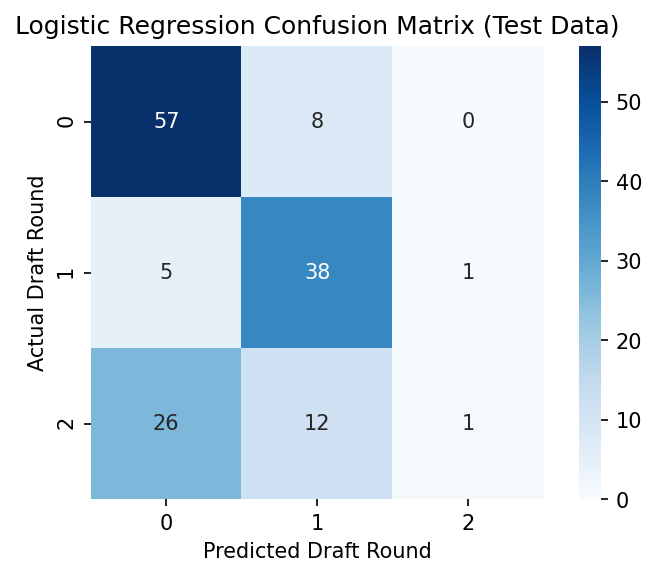

In [872]:
# Confusion matrix for entire training set
lr_confusion = confusion_matrix(y_lr_test,prediction_hard)
plt.figure(dpi=150)
sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Draft Round')
plt.ylabel('Actual Draft Round')
plt.title('Logistic Regression Confusion Matrix (Test Data)');

In [874]:
f_dict={}
for num in range(3):
    f = list(feat for feat in zip(X_lr_train.columns, lr.coef_[num]))
    f_dict[num] = f

print(sorted(f_dict[0], key=lambda x: x[1], reverse=True))
print(sorted(f_dict[1], key=lambda x: x[1], reverse=True))
print(sorted(f_dict[2], key=lambda x: x[1], reverse=True))

[('class_num', 0.11057328940832893), ('fpg', 0.020788274644733377), ('apg', -0.005021587537597551), ('tpg', -0.008382894572169572), ('spg', -0.02757996238503112), ('ppg', -0.028027506159266358), ('vert_std', -0.02814285389389264), ('rpg', -0.028265445846114196), ('true_shooting_percentage', -0.03621826986183927), ('box_plus_minus', -0.07948161572842173)]
[('box_plus_minus', 0.07761503537680328), ('true_shooting_percentage', 0.038567722287251575), ('spg', 0.032642097329390496), ('vert_std', 0.026690107858053744), ('rpg', 0.01641222960781583), ('ppg', 0.015374450521972043), ('apg', 0.00178263145098595), ('tpg', -0.000632602050962677), ('fpg', -0.0015735746152900968), ('class_num', -0.12769762618473968)]
[('class_num', 0.017136155914344812), ('ppg', 0.012662036063050072), ('rpg', 0.011844561133144037), ('tpg', 0.0090123637751162), ('apg', 0.0032481102782712153), ('box_plus_minus', 0.0018723282499202175), ('vert_std', 0.0014480099882439386), ('true_shooting_percentage', -0.0023498067381849